# AGL Autoencoder

Based on https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time
import copy
import itertools

import data

Seed for reproducability

In [2]:
SEED = 54321

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Grammar

In [3]:
class GrammarGen():
    """
    Generates Grammar sequences from grammars, and offers other functionalities
    Grammars are dictionaries:
    - always have START
    - all paths lead eventually to END
    - Entries starting with the same letter
      have same output
    """

    def __init__(self, grammar=None):
        if grammar is None:
            self.grammar = data.g0()
        else:
            self.grammar = grammar

        # find how many letters in grammar
        self.len = len(set([token[0] for token in self.grammar if (token != 'START' and token != 'END')]))

        # variable to check how many sequences have been generated for the grammaticality test
        self.grammCheckMaxLen = -1

    def __len__(self):
        return self.len

    def generate(self, n):
        """Generates n tokens"""
        ret = []
        count = 0
        hashtrack = set()
        while count < n:
            token = []
            current = 'START'
            while current != 'END':
                # Append current
                if current != 'START':
                    token.append(current[0])
                # Choose next
                r = random.randint(0, len(self.grammar[current]) - 1)
                current = self.grammar[current][r]
            # Check if seq is already inside
            tokenhash = ''.join([str(x) for x in token])
            if tokenhash not in hashtrack:
                hashtrack.add(tokenhash)
                ret.append((token, ))
                count += 1

        return ret

    def generateAllGrammatical(self, maxlen=float('inf')):
        """Generates all grammatical sequences until length maxlen"""
        def genAllHelp(seq, current):
            if current == 'END':
                return [seq]
            if len(seq) >= maxlen:
                return []
            # Append Current
            if current != 'START':
                seq.append(current[0])
            # Generate next possibilities
            options = range(len(self.grammar[current]))
            ret = [(genAllHelp(copy.copy(seq), self.grammar[current][i]))
                   for i in options]
            return itertools.chain(*ret)
        return set([tuple(seq) for seq in genAllHelp([], 'START')])

    def isGrammatical(self, seqs):
        """Check for grammaticality of sequences in seqs"""
        maxlen = max([len(seq) for seq in seqs])
        if self.grammCheckMaxLen < maxlen:
            self.allGrammatical = self.generateAllGrammatical(maxlen)
            self.grammCheckMaxLen = maxlen

        return [tuple(seq) in self.allGrammatical for seq in seqs]

## Data

First, get the training and test sequences.

Define a Dataset for Sequences:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
class SequenceDataset(Dataset):
    """
    Dataset for Sequences
    """

    def __init__(self, seqs):
        """
        Args:
            size (int): amount of sequences generated
        """
        self.seqs = seqs

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        return self.seqs[idx]

Define collate_batch for the Dataloader: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

Sequences are padded and their non-padded lengths are returned.
Since pack_padded_sequences requires sequences to be sorted, they are sorted too.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    seq_lens = []
    processed_seqs = []
    # Sort in descending order
    batch.sort(reverse=True, key=(lambda x: len(x)))
    # append start and end token
    for seq in batch:
        seq = [START_TOKEN] + seq + [END_TOKEN]
        seq_lens.append(len(seq))
        processed_seqs.append(torch.tensor(seq))
    # pad
    padded_seqs = pad_sequence(processed_seqs)
    seq_lens = torch.tensor(seq_lens)
    return padded_seqs, seq_lens

## Model


### Encoder

Next up, we define the encoder.

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

In [7]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [8]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [9]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

## Training

In [10]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class CosineLoss():
    def __init__(self, vocabsize, ignore_index):
        self.vocabsize = vocabsize
        self.ignore_index = ignore_index
        self.eye = torch.eye(self.vocabsize)
        self.cosSim = nn.CosineSimilarity(dim=1)

    def __call__(self, outputs, labels):
        maxlen = outputs.shape[0]
        bs = outputs.shape[1]
        ignore_positions = labels == self.ignore_index
        outputs[ignore_positions] = self.eye[self.ignore_index]
        labels_onehot = torch.empty((maxlen, bs, self.vocabsize))
        for idx in range(maxlen):
            labels_onehot[idx,:,:] = self.eye[labels[idx,:]]

        batch_first_labels = labels_onehot.permute(1,0,2)
        processed_labels = batch_first_labels.reshape(-1, maxlen * self.vocabsize)
        batch_first_outputs = outputs.permute(1,0,2)
        processed_outputs = batch_first_outputs.reshape(-1, maxlen * self.vocabsize)
        return (1 - self.cosSim(processed_labels, processed_outputs)).mean()

Training and evaluation functions.

In [11]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch
        trg = src
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        if isinstance(criterion, CosineLoss):
            loss = criterion(output, trg)
        else:
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]
            
            loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [12]:
def evaluate(model, dataloader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for seq, seq_len in dataloader:

            output = model(seq, seq_len, seq, 0) #turn off teacher forcing
            
            #seq = [seq_len, batch_size]
            #output = [seq_len, batch_size, output_dim]

            if isinstance(criterion, CosineLoss):
                loss = criterion(output, seq)
            else:
                output_dim = output.shape[-1]
                
                output = output[1:].view(-1, output_dim)
                trg = seq[1:].view(-1)
                
                #trg = [(trg len - 1) * batch size]
                #output = [(trg len - 1) * batch size, output dim]
                
                loss = criterion(output, trg)

            epoch_loss += loss.item()
            
    return epoch_loss / len(dataloader)

In [79]:
def evaluate_extra(model, dataloader, loss_func):

    model.eval()

    loss_total = 0

    with torch.no_grad():
        
        for seqs, seqs_len in dataloader:

            outputs = model(seqs, seqs_len, seqs, 0)

            loss = loss_func(outputs, seqs) / seqs.shape[1]

            loss_total += loss.item()
        
#        if loss_func == allOrNoneLoss:
#            return loss_total

        return loss_total / len(dataloader)

def cutEndToken(seq):
    ret = []
    for stim in seq:
        if stim == END_TOKEN:
            break
        ret.append(stim)
    return ret


def allOrNoneLoss(output, trg):
    bs = output.shape[1]
    ret = 0
    pred = output.argmax(-1)[1:]
    trg = trg[1:]
    for b in range(bs):
        p = cutEndToken(pred[:,b].tolist())
        t = cutEndToken(trg[:,b].tolist())
        ret += not p == t
    return torch.tensor(ret)

In [40]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

During Training in addition to collecting the train/validation loss, collect the amount of entirely correct predicted sequences on the train and test gr/ugr set.

In [41]:
def fit(model, task_id, epochs, step_size_evaluation, clip ):
    best_valid_loss = float('inf')

    total_hits = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    total_loss = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    # [:,0,:] = train, [:,1,:] = test, [:,2,:] = test_ugr
    # [task_id, dataset, evaluations]

    for epoch in range(epochs):
        
        start_time = time.time()
        
        train_loss = train(model, train_dls[task_id], optimizer, criterion, clip)
        valid_loss = evaluate(model, valid_dls[task_id], criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), SAVENAME)

        if epoch % STEP_SIZE_EVALUATION == 0:
            idx = epoch//STEP_SIZE_EVALUATION
            for other_id in range(task_id + 1):
                total_loss[other_id,0,idx] = evaluate(model, train_dls[other_id], criterion)
                total_loss[other_id,1,idx] = evaluate(model, test_dls[other_id], criterion)
                total_loss[other_id,2,idx] = evaluate(model, test_ugr_dls[other_id], criterion)
                total_hits[other_id,0,idx] = evaluate_extra(model, train_dls[other_id], allOrNoneLoss)
                total_hits[other_id,1,idx] = evaluate_extra(model, test_dls[other_id], allOrNoneLoss)
                total_hits[other_id,2,idx] = evaluate_extra(model, test_ugr_dls[other_id], allOrNoneLoss)

        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    return total_loss, total_hits

# Experiments

1. Load in all the data
2. Set parameters
3. Define plotting functions

## Data

In [42]:
SEED = 54321

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Set base tokens

In [43]:
PAD_TOKEN = 0
START_TOKEN = 1
END_TOKEN = 2

Load data

In [44]:
train_seqs = data.g1_train()
valid_seqs = data.g1_train()
test_seqs = data.g1_test_gr()
test_ugr_seqs = data.g1_test_ugr_balanced()

Sort for better perfomance

In [45]:
train_seqs.sort(key=(lambda x: len(x)))
valid_seqs.sort(key=(lambda x: len(x)))
test_seqs.sort(key=(lambda x: len(x)))
test_ugr_seqs.sort(key=(lambda x: len(x)))

In [46]:
def buildVocab(letterset):
    vocab = {'<pad>': PAD_TOKEN, '<sos>': START_TOKEN, '<eos>': END_TOKEN}
    counter = len(vocab)
    for letter in letterset:
        vocab[letter] = counter
        counter +=1
    return vocab

In [47]:
letters = set()
for seq in train_seqs:
    [letters.add(letter) for letter in seq]
letters = list(letters)

Make all tasks, creates an additional task with all sequences from all tasks mashed together

In [48]:
N_TASKS = 2
BATCH_SIZE = 4

train_dls = []
valid_dls = []
test_dls = []
test_ugr_dls = []
vocabs = []
rvocabs = []
let2idxs = []
idx2lets = []

usedpermutations = set()
train_convs = []
valid_convs = []
test_convs = []
test_ugr_convs = []
for t in range(N_TASKS + 1):
    # Create normal tasks
    if t != N_TASKS:
        temp_letters = copy.copy(letters)

        while str(temp_letters) in usedpermutations:
            random.shuffle(temp_letters)
 
        usedpermutations.add(str(temp_letters))

        # Vocab
        vocabs.append(buildVocab(temp_letters))
        rvocabs.append({v: k for k, v in vocabs[-1].items()})

        # Conversion Functions
        let2idxs.append(lambda seq: [vocabs[-1][let] for let in seq])
        idx2lets.append(lambda seq: [rvocabs[-1][let] for let in seq])

        # Convert to indices
        train_conv = [let2idxs[-1](seq) for seq in train_seqs]
        valid_conv = [let2idxs[-1](seq) for seq in valid_seqs]
        test_conv = [let2idxs[-1](seq) for seq in test_seqs]
        test_ugr_conv = [let2idxs[-1](seq) for seq in test_ugr_seqs]

        # Add conv seq to sequence collection
        train_convs.extend(train_conv)
        valid_convs.extend(valid_conv)
        test_convs.extend(test_conv)
        test_ugr_convs.extend(test_ugr_conv)

    # Create joint task
    else:
        train_conv = train_convs
        valid_conv = valid_convs
        test_conv = test_convs
        test_ugr_conv = test_ugr_convs

    # Datasets
    train_ds = SequenceDataset(train_conv)
    valid_ds = SequenceDataset(valid_conv)
    test_ds = SequenceDataset(test_conv)
    test_ugr_ds = SequenceDataset(test_ugr_conv)
    
    # Dataloader
    train_dls.append(
        DataLoader(train_ds, batch_size=BATCH_SIZE,
                   shuffle=True, collate_fn=collate_batch))
    valid_dls.append(
        DataLoader(valid_ds, batch_size=BATCH_SIZE,
                   shuffle=False, collate_fn=collate_batch))
    test_dls.append(
        DataLoader(test_ds, batch_size=BATCH_SIZE,
                   shuffle=False, collate_fn=collate_batch))
    test_ugr_dls.append(
        DataLoader(test_ugr_ds, batch_size=BATCH_SIZE,
                   shuffle=False, collate_fn=collate_batch))    

In [49]:
print(vocabs[0])
print(vocabs[1])
for i in range(len(valid_dls) - 1):
    for seqs, _ in valid_dls[i]:
        print(f"\nFirst Batch of Task {i}:")
        print(seqs)
        break

{'<pad>': 0, '<sos>': 1, '<eos>': 2, 'W': 3, 'P': 4, 'Z': 5, 'S': 6, 'N': 7}
{'<pad>': 0, '<sos>': 1, '<eos>': 2, 'P': 3, 'Z': 4, 'N': 5, 'W': 6, 'S': 7}

First Batch of Task 0:
tensor([[1, 1, 1, 1],
        [3, 3, 3, 7],
        [6, 3, 6, 7],
        [6, 6, 3, 5],
        [3, 7, 5, 2],
        [5, 5, 2, 0],
        [2, 2, 0, 0]])

First Batch of Task 1:
tensor([[1, 1, 1, 1],
        [6, 6, 6, 5],
        [7, 6, 7, 5],
        [7, 7, 6, 4],
        [6, 5, 4, 2],
        [4, 4, 2, 0],
        [2, 2, 0, 0]])


## Parameters

In [50]:
INPUT_DIM = max(vocabs[0].values()) + 1
OUTPUT_DIM = max(vocabs[0].values()) + 1
ENC_EMB_DIM = 150
DEC_EMB_DIM = 150
ENC_HID_DIM = 18
DEC_HID_DIM = 18
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
LEARNING_RATE = 0.001
SRC_PAD_IDX = PAD_TOKEN
TRG_PAD_IDX = PAD_TOKEN
PREFIX = "tr"
N_EPOCHS = 1000
CLIP = 1
STEP_SIZE_EVALUATION = 10

## Plotting & Evaluation functions

In [96]:
def plotTransfer(data, title):
    # data = [n_methods, n_tasks, combinedepochs]
    n_methods, n_tasks, n_combinedepochs = data.shape
    fig, axs = plt.subplots(n_tasks, 1)
    colors = ['blue','green','orange','red','yellow','violett']
    
    xvals = range(0, n_combinedepochs * STEP_SIZE_EVALUATION, STEP_SIZE_EVALUATION)
    
    for task_idx in range(n_tasks):
        for method_idx in range(n_methods):
            axs[task_idx].plot(
                xvals,
                data[method_idx, task_idx],
                color=colors[method_idx]
            )
            axs[task_idx].set_ylim(0,1.1)
            if task_idx != n_tasks - 1:
                axs[task_idx].tick_params(
                    axis='x',
                    which='both',
                    labelbottom=False
                )
        x_lines = range(0, n_combinedepochs * STEP_SIZE_EVALUATION, N_EPOCHS)
        for xpos in x_lines:
            axs[task_idx].axvline(xpos, color="grey")
    fig.suptitle(title)
    fig.tight_layout()
    
def plotResults(hist_loss, hist_hits):
    plotTransfer( hist_loss[:,0,:].unsqueeze(0), "Train Loss")
    plotTransfer( hist_loss[:,1,:].unsqueeze(0), "Test Gr Loss")
    plotTransfer( hist_loss[:,2,:].unsqueeze(0), "Test Ugr Loss")
    plotTransfer( hist_hits[:,0,:].unsqueeze(0), "Train Hits")
    plotTransfer( hist_hits[:,1,:].unsqueeze(0), "Test Gr Hits")
    plotTransfer( hist_hits[:,2,:].unsqueeze(0), "Test Ugr Hits")

In [60]:
def visual_eval(model, test_dl, ggen=None):

    model.eval()
    
    errors = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(test_dl):

            src, src_len = batch
            trg = src

            output = model(src, src_len, trg, 0) #turn off teacher forcing
            show_batch(output, trg)


def show_batch(output, trg):
    bs = output.shape[1]
    pred = output.argmax(-1)[1:]
    trg = trg[1:]
    for b in range(bs):
        p = cutEndToken(pred[:,b].tolist())
        t = cutEndToken(trg[:,b].tolist())
        status = "same" if p == t else "different"
        print(f"pred = {p} - {status} \ntrg  = {t}\n-")

In [94]:
def accuracy(model):
    for task_id in range(N_TASKS + 1):
        gr_not_hits = evaluate_extra(model, test_dls[task_id], allOrNoneLoss)
        ugr_not_hits = evaluate_extra(model, test_ugr_dls[task_id], allOrNoneLoss)
        gr_hits = 1 - gr_not_hits
        ugr_hits = 1 - ugr_not_hits
        total_acc = (gr_hits + ugr_not_hits) / 2
        print(f"Task {task_id}: Acc {total_acc:2.2}% | Gr acc {gr_hits:2.2} | Ugr acc {ugr_not_hits:2.2}")
        
def accuracyAll(models):
    for model_id in range(len(models)):
        print(f"\nModel {model_id}")
        accuracy(models[model_id])

## Baseline A: Individual Training

In [81]:
SEED = 54321
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [82]:
models_A = []
hist_losses_A = []
hist_hitsss_A = []
for n_task in range(N_TASKS + 1):
    SUFFIX = f"A{n_task}"
    title = f"{PREFIX}-AE-{ENC_EMB_DIM}-{ENC_HID_DIM}-{LEARNING_RATE}-{SUFFIX}"
    LOADNAME = "../models/autosave/" + title + ".pt"
    SAVENAME = "../models/autosave/" + title + ".pt"
    PLOTSAVE = "../plots/autosave/" + title + ".png"

    attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
    model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    criterion = CosineLoss(OUTPUT_DIM, ignore_index=TRG_PAD_IDX)
    
    print(title)
    print(model.apply(init_weights))
    print(f'The model has {count_parameters(model)} trainable parameters')
    
    hist_loss_temp, hist_hits_temp = fit(model, n_task, N_EPOCHS, STEP_SIZE_EVALUATION, CLIP)
    hist_losses_A.append(hist_loss_temp)
    hist_hitsss_A.append(hist_hits_temp)
    models_A.append(model)

tr-AE-150-18-0.001-A0
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8, 150)
    (rnn): GRU(150, 18, bidirectional=True)
    (fc): Linear(in_features=36, out_features=18, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=54, out_features=18, bias=True)
      (v): Linear(in_features=18, out_features=1, bias=False)
    )
    (embedding): Embedding(8, 150)
    (rnn): GRU(186, 18)
    (fc_out): Linear(in_features=204, out_features=8, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
The model has 35198 trainable parameters
Epoch: 01 | Time: 0m 0s
	Train Loss: 0.588 | Train PPL:   1.800
	 Val. Loss: 0.594 |  Val. PPL:   1.812
Epoch: 02 | Time: 0m 0s
	Train Loss: 0.527 | Train PPL:   1.694
	 Val. Loss: 0.614 |  Val. PPL:   1.848
Epoch: 03 | Time: 0m 0s
	Train Loss: 0.530 | Train PPL:   1.699
	 Val. Loss: 0.593 |  Val. PPL:   1.810
Epoch: 04 | Time: 0m 0s
	Train Loss: 0.509 | Tr

Plot Results

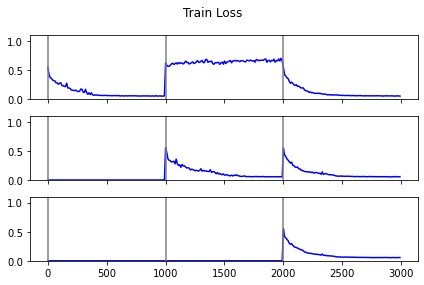

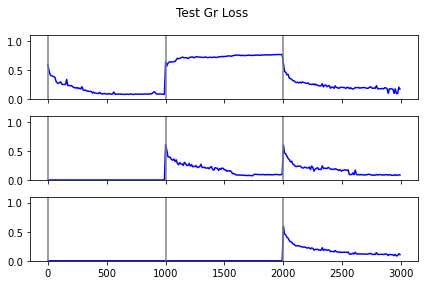

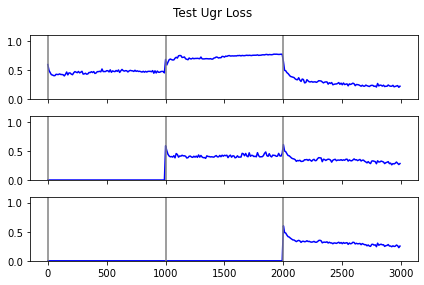

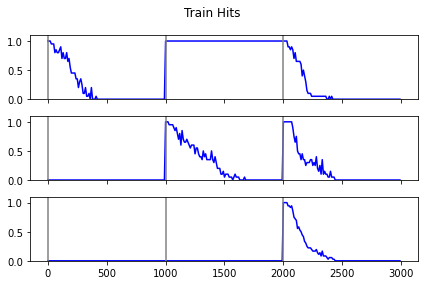

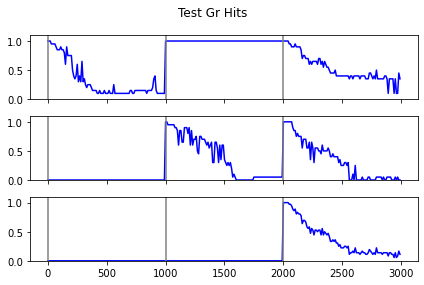

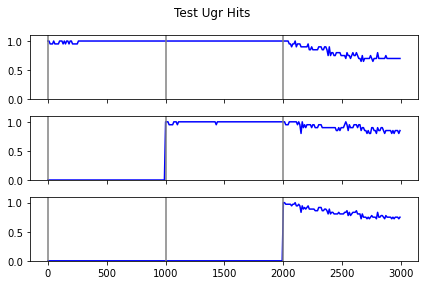

In [98]:
hist_loss_A = torch.cat(hist_losses_A, dim=2)
hist_hits_A = torch.cat(hist_hitsss_A, dim=2)

plotResults(hist_loss_A, hist_hits_A)

In numbers:

In [95]:
accuracyAll(models_A)


Model 0
Task 0: Acc 0.95% | Gr acc 0.9 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.71% | Gr acc 0.42 | Ugr acc 1.0

Model 1
Task 0: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 1: Acc 0.97% | Gr acc 0.95 | Ugr acc 1.0
Task 2: Acc 0.75% | Gr acc 0.5 | Ugr acc 1.0

Model 2
Task 0: Acc 0.77% | Gr acc 0.85 | Ugr acc 0.7
Task 1: Acc 0.93% | Gr acc 1.0 | Ugr acc 0.85
Task 2: Acc 0.83% | Gr acc 0.92 | Ugr acc 0.75


## Baseline B: Keep Training same model

In [101]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [102]:
models_B = []
hist_losses_B = []
hist_hitsss_B = []

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

print(model.apply(init_weights))

for n_task in range(N_TASKS + 1):
    SUFFIX = f"B{n_task}"
    title = f"{PREFIX}-AE-{ENC_EMB_DIM}-{ENC_HID_DIM}-{LEARNING_RATE}-{SUFFIX}"
    LOADNAME = "../models/autosave/" + title + ".pt"
    SAVENAME = "../models/autosave/" + title + ".pt"
    PLOTSAVE = "../plots/autosave/" + title + ".png"
    
    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    criterion = CosineLoss(OUTPUT_DIM, ignore_index=TRG_PAD_IDX)
    
    print(title)
    print(f'The model has {count_parameters(model)} trainable parameters')
    
    hist_loss_temp, hist_hits_temp = fit(model, n_task, N_EPOCHS, STEP_SIZE_EVALUATION, CLIP)
    hist_losses_B.append(hist_loss_temp)
    hist_hitsss_B.append(hist_hits_temp)
    models_B.append(copy.deepcopy(model))

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8, 150)
    (rnn): GRU(150, 18, bidirectional=True)
    (fc): Linear(in_features=36, out_features=18, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=54, out_features=18, bias=True)
      (v): Linear(in_features=18, out_features=1, bias=False)
    )
    (embedding): Embedding(8, 150)
    (rnn): GRU(186, 18)
    (fc_out): Linear(in_features=204, out_features=8, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
tr-AE-150-18-0.001-B0
The model has 35198 trainable parameters
Epoch: 01 | Time: 0m 0s
	Train Loss: 0.588 | Train PPL:   1.800
	 Val. Loss: 0.594 |  Val. PPL:   1.812
Epoch: 02 | Time: 0m 0s
	Train Loss: 0.527 | Train PPL:   1.694
	 Val. Loss: 0.614 |  Val. PPL:   1.848
Epoch: 03 | Time: 0m 0s
	Train Loss: 0.530 | Train PPL:   1.699
	 Val. Loss: 0.593 |  Val. PPL:   1.810
Epoch: 04 | Time: 0m 0s
	Train Loss: 0.509 | Tr

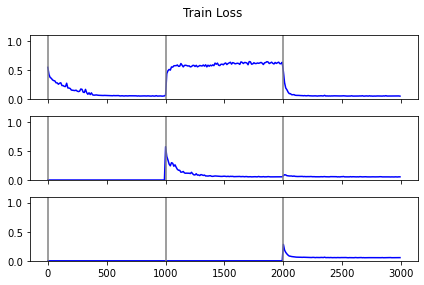

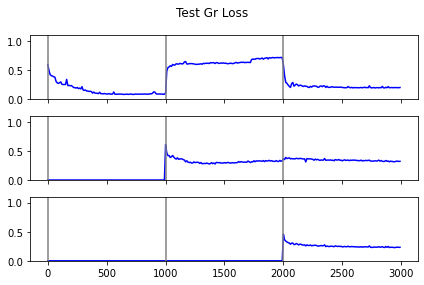

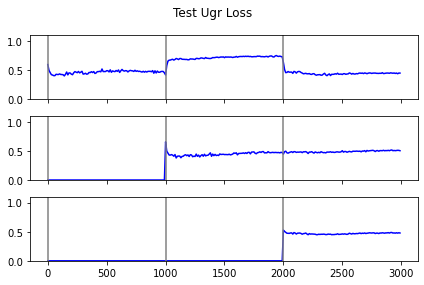

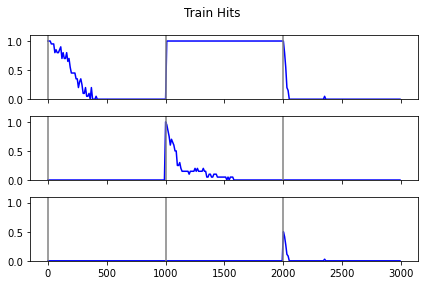

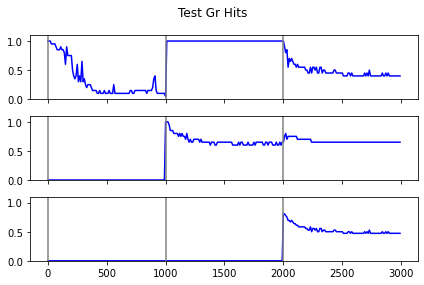

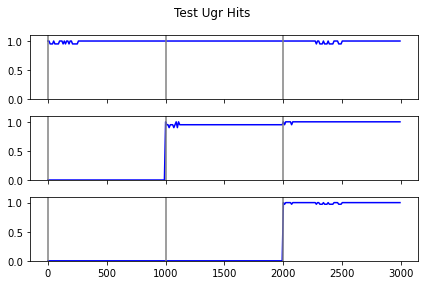

In [103]:
hist_loss_B = torch.cat(hist_losses_B, dim=2)
hist_hits_B = torch.cat(hist_hitsss_B, dim=2)

plotResults(hist_loss_B, hist_hits_B)

In numbers:

In [104]:
accuracyAll(models_B)


Model 0
Task 0: Acc 0.95% | Gr acc 0.9 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.71% | Gr acc 0.42 | Ugr acc 1.0

Model 1
Task 0: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 1: Acc 0.68% | Gr acc 0.4 | Ugr acc 0.95
Task 2: Acc 0.6% | Gr acc 0.22 | Ugr acc 0.97

Model 2
Task 0: Acc 0.8% | Gr acc 0.6 | Ugr acc 1.0
Task 1: Acc 0.68% | Gr acc 0.35 | Ugr acc 1.0
Task 2: Acc 0.76% | Gr acc 0.53 | Ugr acc 1.0


## Baseline C: Freeze Parameters

1. Define functions
2. Train model, freeze core weights in between tasks
3. Look at performance

In [105]:
def applyOnParameters(model, conditions, apply_function):
    for name, param in model.named_parameters():
        # Check every condition
        for condition in conditions:
            # check every keyword
            allincluded = True
            for keyword in condition:
                if keyword not in name:
                    allincluded = False
                    break
            if allincluded:
                apply_function(param)

def freezeParameters(model, conditions):
    def freeze(param):
        param.requires_grad = False
    applyOnParameters(model, conditions, freeze)

def unfreezeParameters(model, conditions):
    def unfreeze(param):
        param.requires_grad = True
    applyOnParameters(model, conditions, unfreeze)

def showModelParameters(model, requires_grad=False):
    for name, param in model.named_parameters():
        if requires_grad:
            if param.requires_grad:
                print(name)
        else:
            print(name)
            
def onTaskUpdate(model):
    # Freeze core weights
    freezeParameters(model, ((""),))    # Freeze everything
    unfreezeParameters(model, (("encoder","embedding"), ("decoder","fc_out"), ("attention",))) # Unfreeze relevant stuff
    
    # Reinitialize
    to_constant = lambda param: nn.init.constant_(param.data, 0)
    applyOnParameters(model, (("decoder","fc_out","bias"),("attn","bias")), to_constant)
    to_normal = lambda param: nn.init.normal_(param.data, mean=0, std=0.01)
    applyOnParameters(model, (("encoder","embedding"),("decoder","fc_out","weight"),("attention","weight")), to_normal)

Train Model

In [111]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [112]:
models_C = []
hist_losses_C = []
hist_hitsss_C = []

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

print(model.apply(init_weights))

for n_task in range(N_TASKS + 1):
    SUFFIX = f"C{n_task}"
    title = f"{PREFIX}-AE-{ENC_EMB_DIM}-{ENC_HID_DIM}-{LEARNING_RATE}-{SUFFIX}"
    LOADNAME = "../models/autosave/" + title + ".pt"
    SAVENAME = "../models/autosave/" + title + ".pt"
    PLOTSAVE = "../plots/autosave/" + title + ".png"
    
    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    criterion = CosineLoss(OUTPUT_DIM, ignore_index=TRG_PAD_IDX)
    
    print(title)
    print(f'The model has {count_parameters(model)} trainable parameters')
    
    hist_loss_temp, hist_hits_temp = fit(model, n_task, N_EPOCHS, STEP_SIZE_EVALUATION, CLIP)
    hist_losses_C.append(hist_loss_temp)
    hist_hitsss_C.append(hist_hits_temp)
    models_C.append(copy.deepcopy(model))
    
    # Freeze, reinitialize
    onTaskUpdate(model)
    

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8, 150)
    (rnn): GRU(150, 18, bidirectional=True)
    (fc): Linear(in_features=36, out_features=18, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=54, out_features=18, bias=True)
      (v): Linear(in_features=18, out_features=1, bias=False)
    )
    (embedding): Embedding(8, 150)
    (rnn): GRU(186, 18)
    (fc_out): Linear(in_features=204, out_features=8, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
tr-AE-150-18-0.001-C0
The model has 35198 trainable parameters
Epoch: 01 | Time: 0m 0s
	Train Loss: 0.588 | Train PPL:   1.800
	 Val. Loss: 0.594 |  Val. PPL:   1.812
Epoch: 02 | Time: 0m 0s
	Train Loss: 0.527 | Train PPL:   1.694
	 Val. Loss: 0.614 |  Val. PPL:   1.848
Epoch: 03 | Time: 0m 0s
	Train Loss: 0.530 | Train PPL:   1.699
	 Val. Loss: 0.593 |  Val. PPL:   1.810
Epoch: 04 | Time: 0m 0s
	Train Loss: 0.509 | Tr

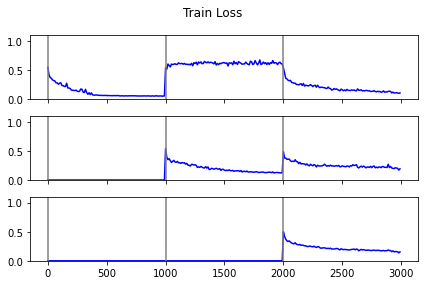

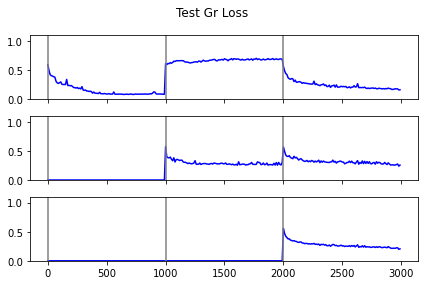

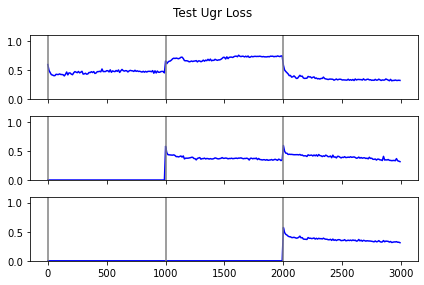

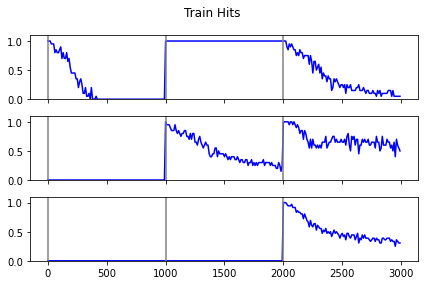

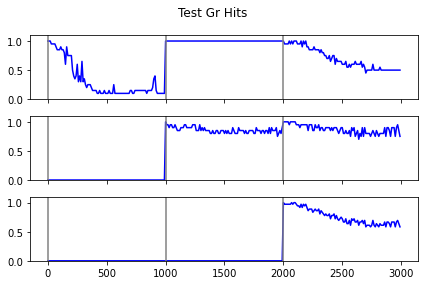

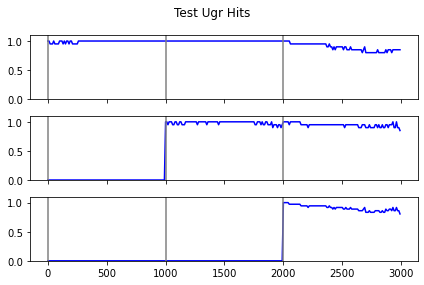

In [113]:
hist_loss_C = torch.cat(hist_losses_C, dim=2)
hist_hits_C = torch.cat(hist_hitsss_C, dim=2)

plotResults(hist_loss_C, hist_hits_C)

In [114]:
accuracyAll(models_C)


Model 0
Task 0: Acc 0.95% | Gr acc 0.9 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.71% | Gr acc 0.42 | Ugr acc 1.0

Model 1
Task 0: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 1: Acc 0.55% | Gr acc 0.15 | Ugr acc 0.95
Task 2: Acc 0.53% | Gr acc 0.083 | Ugr acc 0.97

Model 2
Task 0: Acc 0.68% | Gr acc 0.5 | Ugr acc 0.85
Task 1: Acc 0.55% | Gr acc 0.1 | Ugr acc 1.0
Task 2: Acc 0.62% | Gr acc 0.33 | Ugr acc 0.92


## Transfer D: EWC

1. Create Fisher functions
2. Train model on tasks
3. Compare results

Based on: https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb

In [215]:
fishers = []
optParams = []
ewc_lambda = 2

Compute optimal parameters and fisher information after training on tasks.

In [216]:
def onTaskUpdate_ewc(model, task_id, train_dl, criterion):
    
    model.train()
    optimizer.zero_grad()
    
    #accumulate Gradient
    for it in range(100):
        for seq, seq_len in train_dl:

            optimizer.zero_grad()

            output = model(seq, seq_len, seq, 0)


            #loss = F.cross_entropy(output, seq)
            loss = criterion(output, seq)
            print(loss)

            loss.backward()
        
    fishers.append({})
    optParams.append({})
    
    for name, param in model.named_parameters():
        fishers[task_id][name] = param.grad.data.clone().pow(2)
        optParams[task_id][name] = param.data.clone()

Adapt evaluation and training function.

In [217]:
def train_ewc(model, task_id, dataloader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for seq, seq_len in dataloader:
        
        optimizer.zero_grad()
        
        output = model(seq, seq_len, seq)
        loss = criterion(output, seq)
        
        #if task_id > 0:
        #    print(loss)
        
        # EWC Training penalty
        for other_task_id in range(task_id):
            for name, param in model.named_parameters():
                fisher = fishers[other_task_id][name]
                optParam = optParams[other_task_id][name]
                loss += (ewc_lambda / 2) * (fisher * (optParam - param).pow(2)).sum()
        
        #if task_id > 0:
        #    print(loss)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(dataloader)

In [218]:
def evaluate_ewc(model, task_id, dataloader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():

        for seq, seq_len in dataloader:

            output = model(seq, seq_len, seq, 0) #turn off teacher forcing

            loss = criterion(output, seq).type(torch.float)
            
            # EWC Training penalty
            for other_task_id in range(task_id):
                for name, param in model.named_parameters():
                    fisher = fishers[other_task_id][name]
                    optParam = optParams[other_task_id][name]
                    loss += (ewc_lambda / 2) * (fisher * (optParam - param).pow(2)).sum()
                    
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [219]:
def fit_ewc(model, task_id, epochs, step_size_evaluation, clip ):
    best_valid_loss = float('inf')

    total_hits = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    total_loss = torch.zeros((N_TASKS + 1, 3, epochs//step_size_evaluation,))
    # [:,0,:] = train, [:,1,:] = test, [:,2,:] = test_ugr
    # [task_id, dataset, evaluations]

    for epoch in range(epochs):
        
        start_time = time.time()
        
        train_loss = train_ewc(model, task_id, train_dls[task_id], optimizer, criterion, clip)
        valid_loss = evaluate_ewc(model, task_id, valid_dls[task_id], criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), SAVENAME)

        if epoch % STEP_SIZE_EVALUATION == 0:
            idx = epoch//STEP_SIZE_EVALUATION
            for other_id in range(task_id + 1):
                total_loss[other_id,0,idx] = evaluate_ewc(model, task_id, train_dls[other_id], criterion)
                total_loss[other_id,1,idx] = evaluate_ewc(model, task_id, test_dls[other_id], criterion)
                total_loss[other_id,2,idx] = evaluate_ewc(model, task_id, test_ugr_dls[other_id], criterion)
                total_hits[other_id,0,idx] = evaluate_extra(model, train_dls[other_id], allOrNoneLoss)
                total_hits[other_id,1,idx] = evaluate_extra(model, test_dls[other_id], allOrNoneLoss)
                total_hits[other_id,2,idx] = evaluate_extra(model, test_ugr_dls[other_id], allOrNoneLoss)

        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    return total_loss, total_hits

In [220]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [226]:
torch.max(fishers[0]['encoder.embedding.weight'])

tensor(6.9111e-06)

In [221]:
models_D = []
hist_losses_D = []
hist_hitsss_D = []

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

print(model.apply(init_weights))

for task_id in range(N_TASKS + 1):
    SUFFIX = f"D{task_id}"
    title = f"{PREFIX}-AE-{ENC_EMB_DIM}-{ENC_HID_DIM}-{LEARNING_RATE}-{SUFFIX}"
    LOADNAME = "../models/autosave/" + title + ".pt"
    SAVENAME = "../models/autosave/" + title + ".pt"
    PLOTSAVE = "../plots/autosave/" + title + ".png"
    
    optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
    criterion = CosineLoss(OUTPUT_DIM, ignore_index=TRG_PAD_IDX)
    
    hist_loss_temp, hist_hits_temp = fit_ewc(model, task_id, 500, STEP_SIZE_EVALUATION, CLIP)
    hist_losses_D.append(hist_loss_temp)
    hist_hitsss_D.append(hist_hits_temp)
    models_D.append(copy.deepcopy(model))
    onTaskUpdate_ewc(model, task_id, train_dls[task_id], criterion)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8, 150)
    (rnn): GRU(150, 18, bidirectional=True)
    (fc): Linear(in_features=36, out_features=18, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=54, out_features=18, bias=True)
      (v): Linear(in_features=18, out_features=1, bias=False)
    )
    (embedding): Embedding(8, 150)
    (rnn): GRU(186, 18)
    (fc_out): Linear(in_features=204, out_features=8, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
Epoch: 01 | Time: 0m 0s
	Train Loss: 0.588 | Train PPL:   1.800
	 Val. Loss: 0.594 |  Val. PPL:   1.812
Epoch: 02 | Time: 0m 0s
	Train Loss: 0.527 | Train PPL:   1.694
	 Val. Loss: 0.614 |  Val. PPL:   1.848
Epoch: 03 | Time: 0m 0s
	Train Loss: 0.530 | Train PPL:   1.699
	 Val. Loss: 0.593 |  Val. PPL:   1.810
Epoch: 04 | Time: 0m 0s
	Train Loss: 0.509 | Train PPL:   1.664
	 Val. Loss: 0.580 |  Val. PPL:   1.787
Epoch:

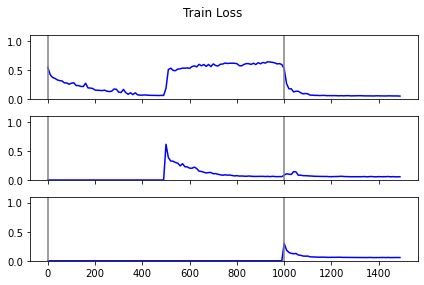

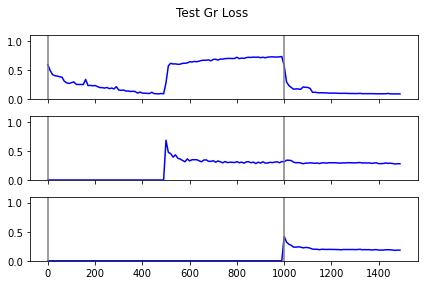

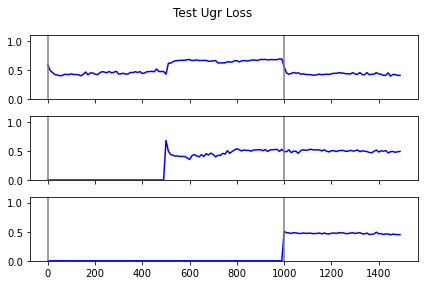

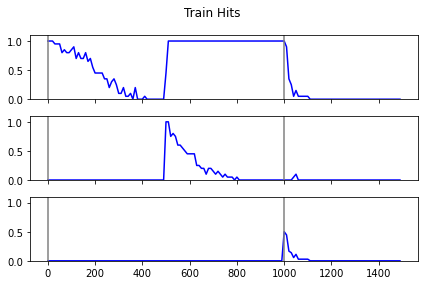

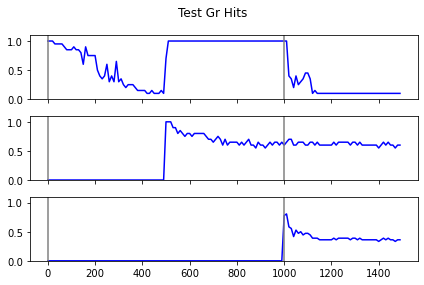

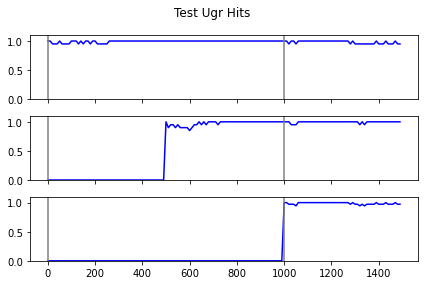

In [222]:
hist_loss_D = torch.cat(hist_losses_D, dim=2)
hist_hits_D = torch.cat(hist_hitsss_D, dim=2)

plotResults(hist_loss_D, hist_hits_D)

In [223]:
accuracyAll(models_D)


Model 0
Task 0: Acc 0.95% | Gr acc 0.9 | Ugr acc 1.0
Task 1: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 2: Acc 0.71% | Gr acc 0.42 | Ugr acc 1.0

Model 1
Task 0: Acc 0.5% | Gr acc 0.0 | Ugr acc 1.0
Task 1: Acc 0.68% | Gr acc 0.35 | Ugr acc 1.0
Task 2: Acc 0.6% | Gr acc 0.19 | Ugr acc 1.0

Model 2
Task 0: Acc 0.93% | Gr acc 0.9 | Ugr acc 0.95
Task 1: Acc 0.7% | Gr acc 0.4 | Ugr acc 1.0
Task 2: Acc 0.81% | Gr acc 0.64 | Ugr acc 0.97


## Transfer D: Representation ensembling

## Transfer E: DynaMoE

1. Create DynaMoe network functions:
2. Decider Network
3. 

In [123]:
class DynaMoE(nn.Module):
    def __init__(self, gating, experts):
        super().__init__()
        
        self.gating = gating
        self.experts = experts
        self.activatedExperts = 1
    
    def forward(self, seqs, seqs_len, trgs, teacher_forcing_ratio = 0.5):
        #seqs = [seqs len, batch size]
        #seqs_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        
        # Decide which expert to use
        gating = self.gating(seqs, seqs_len)
        
        # @TODO: Probabilistic vs argmax?
        network_id = argmax(gating)
        
        outputs = experts[network_id](seqs, seqs_len, teacher_forcing_ratio)
        
        return outputs

SyntaxError: invalid syntax (<ipython-input-123-57aabb6ddb7c>, line 19)

In [ ]:
class Gating(nn.Module):
    def __init__(self, input_dim, embed_dim, n_experts, dropout):
        super().__init__()
        
        self.n_experts = n_experts
        
        self.embedding = nn.Embedding(input_dim, embed_dim)
        
        self.gate = nn.GRU(embed_dim, n_experts)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, seqs, seqs_len):
        
        # seqs = [seq len, batch_size]
        # seqs_len = [batch_size]
        
        embedded = self.dropout(self.embedding(seqs))
        
        # embedded = [seq len, batch_size, embed_dim]
        
        
        
        